# 基于机器学习模型二次融合的产蛋量回归分析

- kaggle数据地址：https://www.kaggle.com/datasets/faysal1998/environmental-effect-on-egg-production

# 数据预处理

## 导入相关包


In [1]:
# 数据处理
import numpy as np
import pandas as pd 
import calendar
from datetime import datetime
from scipy import stats
from scipy.stats import norm

# 数据可视化
import matplotlib.pyplot as plt
import seaborn as sns 

# 模型
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# 杂项
import warnings

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")
%matplotlib inline

import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为 SimHei（黑体）
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


## 认识数据

In [2]:
data = pd.read_csv("Egg_Production.csv")  
data.head()

,Amount_of_chicken,Amount_of_Feeding,Ammonia,Temperature,Humidity,Light_Intensity,Noise,Total_egg_production
0,2728,170,14.4,29.3,51.7,364,214,2115
1,2728,175,17.6,29.3,52.3,369,235,1958
2,2728,175,15.0,29.3,52.5,373,237,1990
3,2728,170,15.0,29.3,49.7,372,240,2015
4,2728,170,15.9,29.2,51.4,381,237,2112


In [3]:
print(f"数据的形状是{data.shape}")

数据的形状是(481, 8)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Amount_of_chicken     481 non-null    int64  
 1   Amount_of_Feeding     481 non-null    int64  
 2   Ammonia               481 non-null    float64
 3   Temperature           481 non-null    float64
 4   Humidity              481 non-null    float64
 5   Light_Intensity       481 non-null    int64  
 6   Noise                 481 non-null    int64  
 7   Total_egg_production  481 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 30.2 KB


## 描述性统计

### 观察连续特征对于标签的影响

<Axes: >

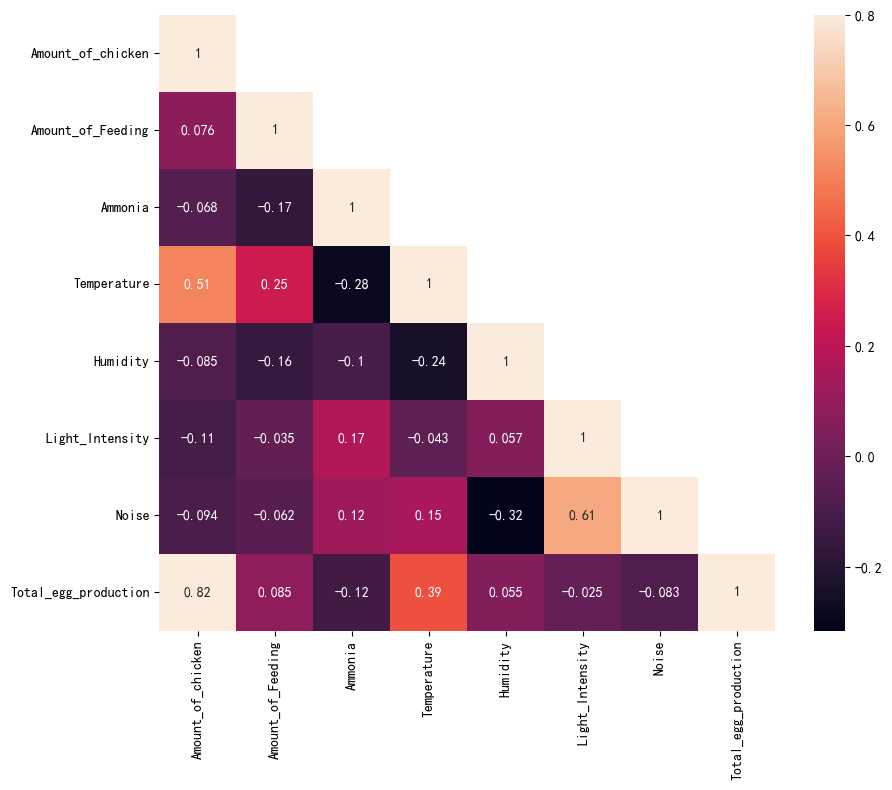

In [6]:
# 绘制原始数据的热力图，查看特征之间的相关性
corr_df = data[["Amount_of_chicken", "Amount_of_Feeding", "Ammonia", "Temperature", "Humidity","Light_Intensity","Noise","Total_egg_production"]].corr()
mask = np.array(corr_df)
mask[np.tril_indices_from(mask)] = False  # mask = np.zeros_like(corr) # mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, mask=mask, vmax=0.8, square=True, annot=True)

相关性分析：
总产蛋量与鸡的数量相关系数为 0.82，颜色较白，说明鸡的数量越多，总产蛋量往往越高，呈较强正相关。
总产蛋量和温度相关系数是 0.39，显示一定红色，意味着温度升高时，总产蛋量可能也会增加。
总产蛋量与氨气含量相关系数为 -0.12 ，颜色偏黑，表明氨气含量增加时，总产蛋量可能降低 。


## 划分数据

In [10]:
# 分离特征数据和标签数据
X = data.drop(['Total_egg_production'], axis=1)  # 特征数据
y = data['Total_egg_production']  # 标签数据

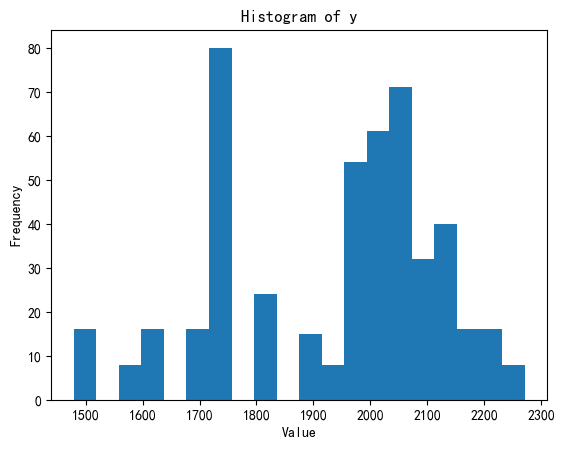

In [11]:
import matplotlib.pyplot as plt
y = data['Total_egg_production'] 
# 绘制直方图
plt.hist(y, bins=20)  # bins 参数可以调整直方图的柱子数量

# 添加标题和坐标轴标签
plt.title('Histogram of y')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 显示图形
plt.show()

可以看到这里在值=1900以前数据较为分散，其中值=1700~1800时有较高的频率，最后我们预测的误差可以对比下这个判断多少算多

In [12]:
# 使用 train_test_split 函数按照 8:2 的比例划分数据集
# test_size=0.2 表示 20%的数据用作测试集，即验证集。
# random_state 是一个随机数种子，确保每次划分的结果相同，便于复现结果。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(384, 7) (97, 7) (384,) (97,)


## 异常值处理

- 利用箱线图可视化连续特征

Index(['Amount_of_chicken', 'Amount_of_Feeding', 'Ammonia', 'Temperature',
       'Humidity', 'Light_Intensity', 'Noise'],
      dtype='object')


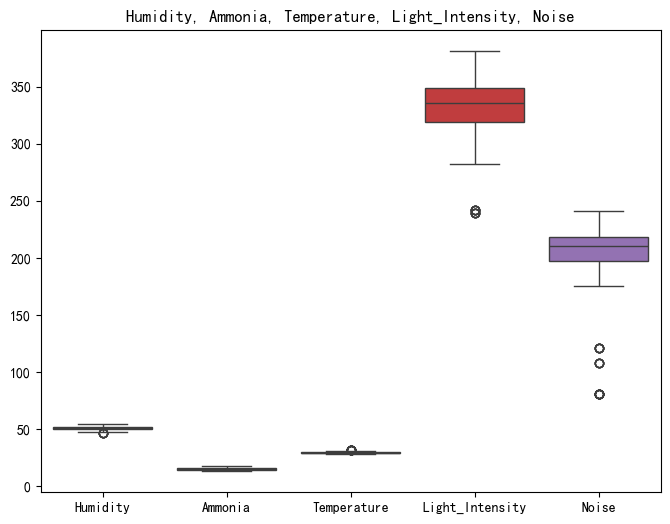

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 X_train 是你的训练数据集
# 检查列名是否存在
print(X_train.columns)

# 绘制箱线图
plt.figure(figsize=(8, 6))
sns.boxplot(data=X_train[['Humidity', 'Ammonia', 'Temperature', 'Light_Intensity', 'Noise']])
plt.title("Humidity, Ammonia, Temperature, Light_Intensity, Noise")
plt.show()


- 此处未处理异常值，因异常值数量较少，对模型影响极小，可忽略不计

In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8690 entries, 2815 to 7270
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      8690 non-null   int64  
 1   holiday     8690 non-null   int64  
 2   workingday  8690 non-null   int64  
 3   weather     8690 non-null   int64  
 4   temp        8690 non-null   float64
 5   humidity    8690 non-null   int64  
 6   windspeed   8690 non-null   float64
 7   month       8690 non-null   int32  
 8   day         8690 non-null   int32  
 9   weekday     8690 non-null   int32  
 10  hour        8690 non-null   int32  
dtypes: float64(2), int32(4), int64(5)
memory usage: 678.9 KB


# 回归任务-机器学习建模

## 线性回归

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 初始化模型
linear_model = LinearRegression()

# 训练模型
linear_model.fit(X_train, y_train)

# 预测
y_test_pred = linear_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"线性回归线性回归模型测试集 RMSE: 107.1537模型测试集 RMSE: {test_rmse:.4f}")

线性回归模型测试集 RMSE: 107.1537


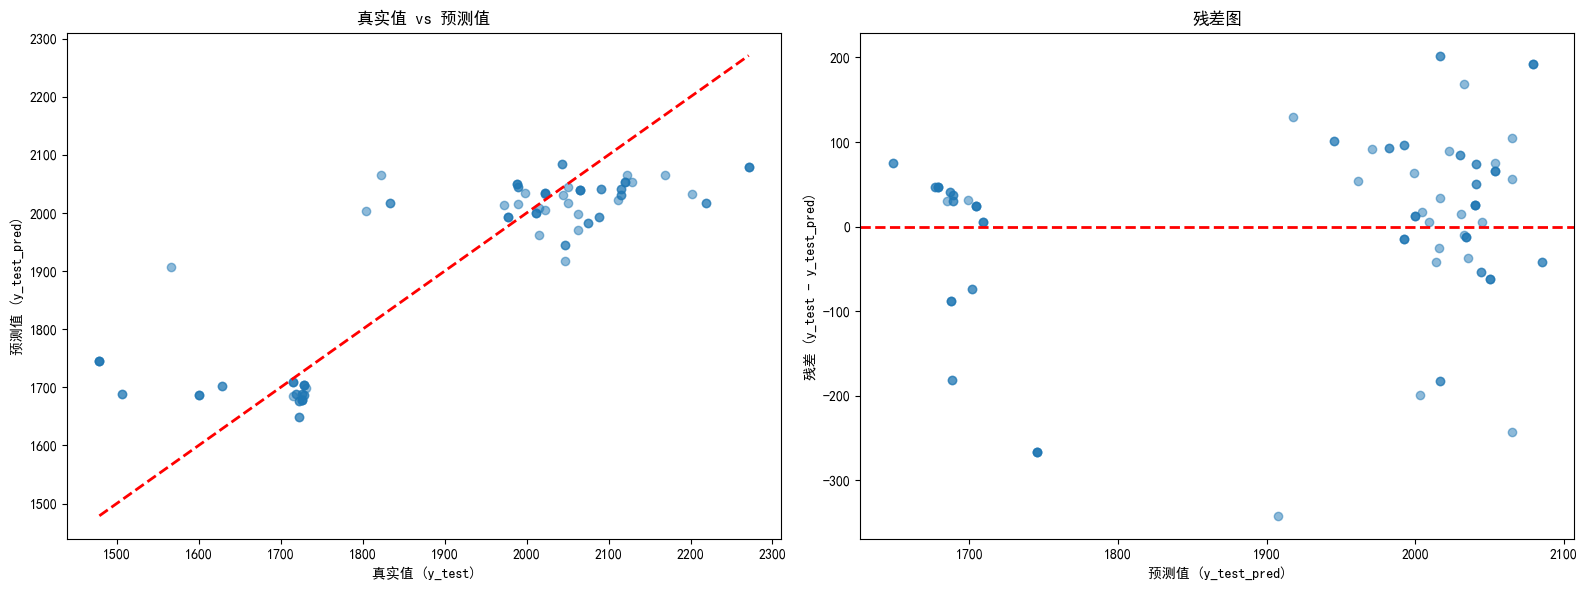

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为 SimHei（黑体）
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


# 创建图形
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. 真实值 vs 预测值
axes[0].scatter(y_test, y_test_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # 绘制 y = x 的参考线
axes[0].set_xlabel("真实值 (y_test)")
axes[0].set_ylabel("预测值 (y_test_pred)")
axes[0].set_title("真实值 vs 预测值")

# 2. 残差图
residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)  # 绘制 y = 0 的参考线
axes[1].set_xlabel("预测值 (y_test_pred)")
axes[1].set_ylabel("残差 (y_test - y_test_pred)")
axes[1].set_title("残差图")

# 显示图形
plt.tight_layout()
plt.show()

## lASSO回归

In [22]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# 初始化 Lasso 回归模型
lasso_model = Lasso(alpha=0.01, random_state=42)  # alpha 是正则化强度

# 训练模型
lasso_model.fit(X_train, y_train)

# 预测
y_test_pred = lasso_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"Lasso 回归模型测试集 RMSE: {test_rmse:.4f}")

Lasso 回归模型测试集 RMSE: 107.1547


## 弹性网

In [23]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

# 初始化弹性网络模型
elastic_net_model = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42)  # alpha 是正则化强度，l1_ratio 是 L1 正则化的比例

# 训练模型
elastic_net_model.fit(X_train, y_train)

# 预测
y_test_pred = elastic_net_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"弹性网络模型测试集 RMSE: {test_rmse:.4f}")

弹性网络模型测试集 RMSE: 107.1593


## 支持向量机

In [24]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# 标准化数据（SVR 对数据尺度敏感）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 初始化 SVR 模型
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # 使用径向基函数（RBF）核

# 训练模型
svr_model.fit(X_train_scaled, y_train)

# 预测
y_test_pred = svr_model.predict(X_test_scaled)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"SVR 模型测试集 RMSE: {test_rmse:.4f}")

SVR 模型测试集 RMSE: 203.6374


In [25]:
from sklearn.model_selection import GridSearchCV

# 定义参数网格
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2]
}

# 初始化 GridSearchCV
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# 输出最优参数
print(f"最优参数: {grid_search.best_params_}")

# 使用最优参数训练模型
svr_model = grid_search.best_estimator_
svr_model.fit(X_train_scaled, y_train)

# 预测
y_test_pred = svr_model.predict(X_test_scaled)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"SVR 模型测试集 RMSE: {test_rmse:.4f}")

最优参数: {'C': 10, 'epsilon': 0.01, 'kernel': 'linear'}
SVR 模型测试集 RMSE: 116.2840


## KNN

In [26]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# 初始化 KNN 回归模型（使用默认参数）
knn_model = KNeighborsRegressor()

# 训练模型
knn_model.fit(X_train, y_train)

# 预测
y_test_pred = knn_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"KNN 默认参数模型测试集 RMSE: {test_rmse:.4f}")

KNN 默认参数模型测试集 RMSE: 10.6013


## 决策树  

In [27]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# 初始化决策树回归模型（使用默认参数）
dt_model = DecisionTreeRegressor(random_state=42)

# 训练模型
dt_model.fit(X_train, y_train)

# 预测
y_test_pred = dt_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"决策树默认参数模型测试集 RMSE: {test_rmse:.4f}")

决策树默认参数模型测试集 RMSE: 0.0000


可能由于样本量较小，故出现RMSE等于零的情况。，但这并不代表模型在大规模数据上也能保持这样的性能。

## 随机森林

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 初始化随机森林回归模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # n_estimators 是树的数量

# 训练模型
rf_model.fit(X_train, y_train)

# 预测
y_test_pred = rf_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"随机森林回归模型测试集 RMSE: {test_rmse:.4f}")

随机森林回归模型测试集 RMSE: 1.4622


In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# 定义参数网格
param_grid = {
    'n_estimators': [50, 100, 200],  # 树的数量
    'max_depth': [None, 10, 20, 30],  # 树的最大深度
    'min_samples_split': [2, 5, 10],  # 节点分裂所需的最小样本数
    'min_samples_leaf': [1, 2, 4],  # 叶节点所需的最小样本数
    'max_features': ['auto', 'sqrt', 'log2']  # 每个节点分裂时考虑的最大特征数
}

# 初始化随机森林回归模型
rf_model = RandomForestRegressor(random_state=42)

# 初始化 GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,  # 5 折交叉验证
    scoring='neg_mean_squared_error',  # 使用负均方误差作为评分指标
    n_jobs=1  # 使用所有可用的 CPU 核心
)

# 执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最优参数
print(f"最优参数: {grid_search.best_params_}")

# 使用最优参数训练模型
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# 预测
y_test_pred = best_rf_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"随机森林回归模型测试集 RMSE: {test_rmse:.4f}")

最优参数: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
随机森林回归模型测试集 RMSE: 1.4332



因为参数比较多，这个网格搜索的比较粗糙，RMSE减小的也不多，可以进一步基于默认的参数进行细致的搜索。

In [30]:
from sklearn.ensemble import RandomForestRegressor

# 初始化随机森林回归模型（使用默认参数）
rf_model_default = RandomForestRegressor(random_state=42)

# 打印默认参数
print("随机森林回归模型的默认参数：")
print(rf_model_default.get_params())

随机森林回归模型的默认参数：
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [31]:
# 基于默认参数来调参
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# 定义小范围参数网格
param_grid = {
    'n_estimators': [80, 100, 120],  # 在默认值 100 附近搜索
    'max_features': [0.8, 1.0],  # 在默认值 1.0 附近搜索
    'max_depth': [None, 10, 20],  # 在默认值 None 附近搜索
    'min_samples_split': [2, 4, 6],  # 在默认值 2 附近搜索
    'min_samples_leaf': [1, 2, 3]  # 在默认值 1 附近搜索
}

# 初始化随机森林回归模型
rf_model = RandomForestRegressor(random_state=42)

# 初始化 GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,  # 5 折交叉验证
    scoring='neg_mean_squared_error',  # 使用负均方误差作为评分指标
    n_jobs=1  # 使用所有可用的 CPU 核心
)

# 执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最优参数
print(f"最优参数: {grid_search.best_params_}")

# 使用最优参数训练模型
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# 预测
y_test_pred = best_rf_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"随机森林回归模型测试集 RMSE: {test_rmse:.4f}")

最优参数: {'max_depth': None, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}
随机森林回归模型测试集 RMSE: 1.3333


将这些最优参数与之前提到的默认参数 {'max_depth': None, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120} 对比可以发现， 对max_features 和 n_estimators的调整为模型增加了性能



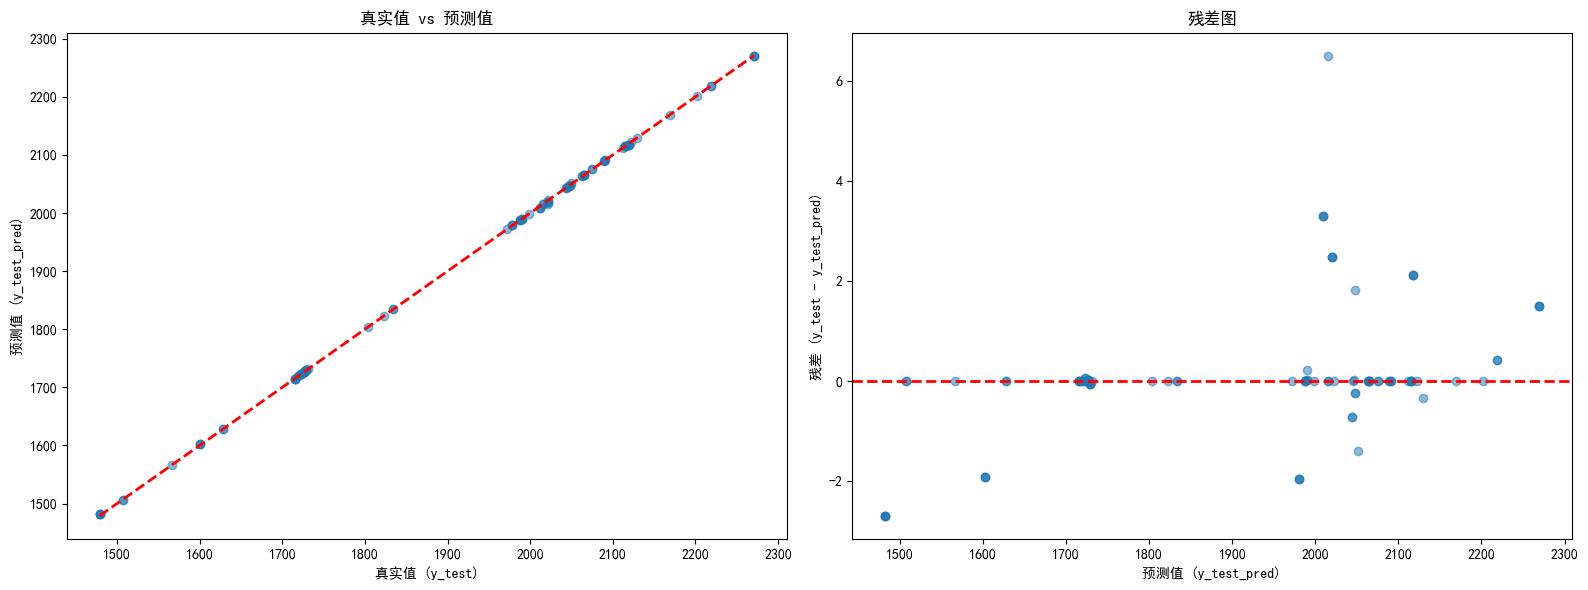

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为 SimHei（黑体）
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


# 创建图形
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. 真实值 vs 预测值
axes[0].scatter(y_test, y_test_pred, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # 绘制 y = x 的参考线
axes[0].set_xlabel("真实值 (y_test)")
axes[0].set_ylabel("预测值 (y_test_pred)")
axes[0].set_title("真实值 vs 预测值")

# 2. 残差图
residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)  # 绘制 y = 0 的参考线
axes[1].set_xlabel("预测值 (y_test_pred)")
axes[1].set_ylabel("残差 (y_test - y_test_pred)")
axes[1].set_title("残差图")

# 显示图形
plt.tight_layout()
plt.show()

## XGboost

In [33]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# 初始化 XGBoost 回归模型（使用默认参数）
xgb_model = XGBRegressor(random_state=42)

# 训练模型
xgb_model.fit(X_train, y_train)

# 预测
y_test_pred = xgb_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"XGBoost 默认参数模型测试集 RMSE: {test_rmse:.4f}")


# 打印默认参数
print("XGBoost 默认参数：")
print(xgb_model.get_params())

XGBoost 默认参数模型测试集 RMSE: 2.0222
XGBoost 默认参数：
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [34]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# 定义参数网格
param_grid = {
    'n_estimators': [50, 100, 150],  # 树的数量
    'max_depth': [3, 6, 9],  # 树的最大深度
    'learning_rate': [0.01, 0.1, 0.3],  # 学习率
    'subsample': [0.8, 1.0],  # 每棵树使用的样本比例
    'colsample_bytree': [0.8, 1.0],  # 每棵树使用的特征比例
    'reg_alpha': [0, 0.1, 1],  # L1 正则化系数
    'reg_lambda': [0, 0.1, 1]  # L2 正则化系数
}

# 初始化 XGBoost 回归模型
xgb_model = XGBRegressor(random_state=42)

# 初始化 GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,  # 5 折交叉验证
    scoring='neg_mean_squared_error',  # 使用负均方误差作为评分指标
    n_jobs=1  # 使用所有可用的 CPU 核心
)

# 执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最优参数
print(f"最优参数: {grid_search.best_params_}")

# 使用最优参数训练模型
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

# 预测
y_test_pred = best_xgb_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"优化后 XGBoost 模型测试集 RMSE: {test_rmse:.4f}")

最优参数: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 1.0}
优化后 XGBoost 模型测试集 RMSE: 0.0003


可以看到XGBoost在经历网格搜索调参后该数据集上的表现良好

In [35]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# 初始化 LightGBM 回归模型（使用默认参数）
lgbm_model = LGBMRegressor(random_state=42)

# 训练模型
lgbm_model.fit(X_train, y_train)

# 预测
y_test_pred = lgbm_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"LightGBM 默认参数模型测试集 RMSE: {test_rmse:.4f}")
# 打印默认参数

print("LightGBM 默认参数：")
print(lgbm_model.get_params())

Exception in thread Thread-26:
Traceback (most recent call last):
  File "d:\anaconda\envs\vs\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "d:\anaconda\envs\vs\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "d:\anaconda\envs\vs\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "d:\anaconda\envs\vs\lib\subprocess.py", line 1386, in _readerthread
    buffer.append(fh.read())
  File "d:\anaconda\envs\vs\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb6 in position 24: invalid start byte


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 384, number of used features: 7
[LightGBM] [Info] Start training from score 1942.002604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

  File "d:\anaconda\envs\vs\lib\site-packages\joblib\externals\loky\backend\context.py", line 262, in _count_physical_cores
    cpu_info = cpu_info.stdout.splitlines()


以上[Warning] No further splits with positive gain, best gain说明在树的生长过程中，找不到能带来正增益的分裂点。这可能是因为数据已经被充分划分，或者特征的区分度不够，导致无法通过进一步分裂节点来提高模型性能。也可能暗示模型已经达到了过拟合的状态，或者数据本身不适合使用决策树类的模型进行建模。根据前面随机森林和XGBoost的RMSE可见并非数据集不适合决策树类的模型。由于数据集较小，过拟合导致该模型RESM相对较大的可能性较高。

In [49]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# 初始化 LightGBM 模型
lgbm_model = LGBMRegressor(random_state=42)

# 定义参数网格
param_grid = {
    'num_leaves': [14.5, 15, 15.5],  # 尝试不同的叶子节点数
    'learning_rate': [0.1, 0.05, 0.01],  # 尝试不同的学习率
    'subsample': [0.8, 1.0],  # 尝试不同的样本采样比例
    'colsample_bytree': [0.8, 1.0]  # 尝试不同的特征采样比例
}

# 使用网格搜索调参
grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数：", grid_search.best_params_)

# 使用最佳参数训练模型
best_lgbm_model = grid_search.best_estimator_
y_test_pred = best_lgbm_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"调参后模型测试集 RMSE: {test_rmse:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 384, number of used features: 7
[LightGBM] [Info] Start training from score 1942.002604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

## **模型初步评估结果**

| 模型名称               | 测试集 RMSE   |
|------------------------|---------------|
| 线性回归模型           | 107.1537      |
| Lasso 回归模型         | 107.1547      |
| 弹性网络模型           | 107.1593      |
| SVR 模型               | 116.2840      |
| KNN 默认参数模型       | 10.6013      |
| 随机森林回归模型       | 1.3333       |
| XGBoost 模型           | 0.0003       |
| LightGBM 模型          | 4.0787        |

---

**说明**
 **RMSE**：均方根误差（Root Mean Squared Error），值越小表示模型性能越好。


## stacking 模型融合

In [50]:
from sklearn.ensemble import StackingRegressor

# 定义基模型
base_models = [
    ('lasso', Lasso()),  # KNN 回归
    ('svr', SVR()),  # 支持向量回归
    ('elasticnet', ElasticNet())  # 线性回归
]

# 定义元模型（XGBoost）
meta_model = XGBRegressor(random_state=42)

# 创建 Stacking 回归器
stacking_model = StackingRegressor(
    estimators=base_models,  # 基模型
    final_estimator=meta_model,  # 元模型
    cv=5,  # 交叉验证折数
    n_jobs=1  # 使用所有 CPU 核心
)

# 训练 Stacking 模型
stacking_model.fit(X_train, y_train)

# 预测
y_test_pred = stacking_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

# 输出结果
print(f"Stacking 模型测试集 RMSE: {test_rmse:.4f}")

# 打印 Stacking 模型的参数
print("Stacking 模型参数：")
print(stacking_model.get_params())

Stacking 模型测试集 RMSE: 87.7182
Stacking 模型参数：
{'cv': 5, 'estimators': [('lasso', Lasso()), ('svr', SVR()), ('elasticnet', ElasticNet())], 'final_estimator__objective': 'reg:squarederror', 'final_estimator__base_score': None, 'final_estimator__booster': None, 'final_estimator__callbacks': None, 'final_estimator__colsample_bylevel': None, 'final_estimator__colsample_bynode': None, 'final_estimator__colsample_bytree': None, 'final_estimator__device': None, 'final_estimator__early_stopping_rounds': None, 'final_estimator__enable_categorical': False, 'final_estimator__eval_metric': None, 'final_estimator__feature_types': None, 'final_estimator__gamma': None, 'final_estimator__grow_policy': None, 'final_estimator__importance_type': None, 'final_estimator__interaction_constraints': None, 'final_estimator__learning_rate': None, 'final_estimator__max_bin': None, 'final_estimator__max_cat_threshold': None, 'final_estimator__max_cat_to_onehot': None, 'final_estimator__max_delta_step': None, 'final_

可以看到，效果不好，因为基模型的回归预测性能太差

In [ ]:
# 尝试3个集成学习作为基模型，xgboost作为元模型
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# 定义基模型（使用调参后的最优参数）
base_models = [
    ('rf', RandomForestRegressor(
        max_depth=None,  # 最优参数
        max_features=0.8,  # 最优参数
        min_samples_leaf=1,  # 最优参数
        min_samples_split=2,  # 最优参数
        n_estimators=120,  # 最优参数
        random_state=42
    )),  # 随机森林
    ('xgb', XGBRegressor(
        colsample_bytree=1.0,  # 最优参数
        learning_rate=0.3,  # 最优参数
        max_depth=9,  # 最优参数
        n_estimators=50,  # 最优参数
        reg_alpha=0,  # 最优参数
        reg_lambda=0.1,  # 最优参数
        subsample=1.0,  # 最优参数
        random_state=42
    )),  # XGBoost
    ('lgbm', LGBMRegressor(
        colsample_bytree=1.0,  # 最优参数
        learning_rate=0.1,  # 最优参数
        num_leaves=15,  # 最优参数
        subsample=0.8,  # 最优参数
        random_state=42
    ))  # LightGBM
]

# 定义元模型（进一步调参的 XGBoost）
meta_model = XGBRegressor(
    colsample_bytree=0.9,  # 微调
    learning_rate=0.1,  # 降低学习率
    max_depth=7,  # 微调
    n_estimators=100,  # 增加树的数量
    reg_alpha=0.1,  # 微调 L1 正则化
    reg_lambda=0.5,  # 微调 L2 正则化
    subsample=0.9,  # 微调
    random_state=42
)

# 创建 Stacking 回归器
stacking_model = StackingRegressor(
    estimators=base_models,  # 基模型
    final_estimator=meta_model,  # 元模型
    n_jobs=-1  # 使用所有 CPU 核心
)

# 训练 Stacking 模型
stacking_model.fit(X_train, y_train)

# 预测
y_test_pred = stacking_model.predict(X_test)

# 计算 RMSE
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"调参后 Stacking 模型测试集 RMSE: {test_rmse:.4f}")

调参后 Stacking 模型测试集 RMSE: 2.3268


In [55]:
# # 尝试3个集成学习作为基模型，随机森林作为元模型
from lightgbm import LGBMRegressor

# 定义基模型（使用调参后的最优参数）
base_models = [
    ('rf', RandomForestRegressor(
        max_depth=None,  # 最优参数
        max_features=0.8,  # 最优参数
        min_samples_leaf=1,  # 最优参数
        min_samples_split=2,  # 最优参数
        n_estimators=120,  # 最优参数
        random_state=42
    )),  # 随机森林
    ('xgb', XGBRegressor(
         colsample_bytree=1.0,  # 最优参数
        learning_rate=0.3,  # 最优参数
        max_depth=9,  # 最优参数
        n_estimators=50,  # 最优参数
        reg_alpha=0,  # 最优参数
        reg_lambda=0.1,  # 最优参数
        subsample=1.0,  # 最优参数
        random_state=42
    )),  # XGBoost
    ('lgbm', LGBMRegressor(
        colsample_bytree=1.0,  # 最优参数
        learning_rate=0.1,  # 最优参数
        num_leaves=15,  # 最优参数
        subsample=0.8,  # 最优参数
        random_state=42
    ))  # LightGBM
]
# 定义元模型（随机森林）
meta_model_随机森林 = RandomForestRegressor(
    max_depth=None,
    max_features=0.8,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=120,
    random_state=42  # 保持随机结果可复现
)

# 创建 Stacking 回归器
stacking_model_随机森林 = StackingRegressor(
    estimators=base_models,  # 基模型
    final_estimator=meta_model_随机森林,  # 随机森林 作为元模型
    n_jobs=1  # 使用所有 CPU 核心
)

# 训练 Stacking 模型
stacking_model_随机森林.fit(X_train, y_train)

# 预测
y_test_pred_lgbm = stacking_model_随机森林.predict(X_test)

# 计算 RMSE
test_rmse_随机森林 = mean_squared_error(y_test, y_test_pred_lgbm, squared=False)
print(f"使用 随机森林 作为元模型的 Stacking 测试集 RMSE: {test_rmse_随机森林:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 384, number of used features: 7
[LightGBM] [Info] Start training from score 1942.002604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

## 加权融合

In [56]:

# 定义基模型（使用你提供的参数）
base_models = [
    ('rf', RandomForestRegressor(
        max_depth=None,
        max_features=0.8,
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=120,
        random_state=42
    )),  # 随机森林
    ('xgb', XGBRegressor(
        colsample_bytree=1.0,  # 最优参数
        learning_rate=0.3,  # 最优参数
        max_depth=9,  # 最优参数
        n_estimators=50,  # 最优参数
        reg_alpha=0,  # 最优参数
        reg_lambda=0.1,  # 最优参数
        subsample=1.0,  # 最优参数
        random_state=42
    )),  # XGBoost
    ('lgbm', LGBMRegressor(
        colsample_bytree=1.0,  # 最优参数
        learning_rate=0.1,  # 最优参数
        num_leaves=15,  # 最优参数
        subsample=0.8,  # 最优参数
        random_state=42
    ))  # LightGBM
]

# 训练基模型
for name, model in base_models:
    model.fit(X_train, y_train)
    print(f"{name} 模型训练完成")

# 获取每个模型的预测结果
y_test_pred_rf = base_models[0][1].predict(X_test)  # 随机森林
y_test_pred_xgb = base_models[1][1].predict(X_test)  # XGBoost
y_test_pred_lgbm = base_models[2][1].predict(X_test)  # LightGBM

# 定义网格搜索范围
weights_rf = np.linspace(0, 1, 11)  # 随机森林权重范围 [0, 0.1, ..., 1]
weights_xgb = np.linspace(0, 1, 11)  # XGBoost 权重范围 [0, 0.1, ..., 1]
weights_lgbm = np.linspace(0, 1, 11)  # LightGBM 权重范围 [0, 0.1, ..., 1]

# 初始化最佳 RMSE 和最佳权重
best_rmse = float('inf')
best_weights = None

# 网格搜索
for w_rf in weights_rf:
    for w_xgb in weights_xgb:
        for w_lgbm in weights_lgbm:
            if w_rf + w_xgb + w_lgbm == 1:  # 确保权重之和为 1
                # 加权平均
                y_test_pred_weighted = (w_rf * y_test_pred_rf +
                                        w_xgb * y_test_pred_xgb +
                                        w_lgbm * y_test_pred_lgbm)
                # 计算 RMSE
                test_rmse = mean_squared_error(y_test, y_test_pred_weighted, squared=False)
                # 更新最佳权重
                if test_rmse < best_rmse:
                    best_rmse = test_rmse
                    best_weights = (w_rf, w_xgb, w_lgbm)

# 输出最佳权重和 RMSE
print(f"最佳权重：随机森林={best_weights[0]:.2f}, XGBoost={best_weights[1]:.2f}, LightGBM={best_weights[2]:.2f}")
print(f"最佳 RMSE: {best_rmse:.4f}")

rf 模型训练完成
xgb 模型训练完成
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 384, number of used features: 7
[LightGBM] [Info] Start training from score 1942.002604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

## **模型最终评估结果**


| 模型名称               | 测试集 RMSE   |
|------------------------|---------------|
| 线性回归模型           | 107.1537      |
| Lasso 回归模型         | 107.1547      |
| 弹性网络模型           | 107.1593      |
| SVR 模型               | 116.2840      |
| KNN 默认参数模型       | 10.6013      |
| 随机森林回归模型       | 1.3333       |
| XGBoost 模型           | 0.0003       |
| LightGBM 模型          | 4.0787        |
| stacking模型          | 0.6635       |
| 加权融合模型          | 0.0003      |

---

**说明**
- **RMSE**：均方根误差（Root Mean Squared Error），值越小表示模型性能越好。

 


# 可解释性分析

In [57]:

data = pd.read_csv("Egg_Production.csv")  
# 分离特征数据和标签数据
X = data.drop(['Total_egg_production'], axis=1)  # 特征数据
y = data['Total_egg_production']  # 标签数据
# 使用 train_test_split 函数按照 8:2 的比例划分数据集
# test_size=0.2 表示 20%的数据用作测试集，即验证集。
# random_state 是一个随机数种子，确保每次划分的结果相同，便于复现结果。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [58]:
X_train

,Amount_of_chicken,Amount_of_Feeding,Ammonia,Temperature,Humidity,Light_Intensity,Noise
228,2736,180,13.5,30.0,50.2,313,215
474,2736,195,15.7,29.5,52.7,329,204
42,2740,190,13.7,32.0,49.9,305,232
261,2649,180,13.7,29.0,50.5,324,192
402,2742,195,14.6,31.0,50.9,326,218
...,...,...,...,...,...,...,...
106,2736,180,13.5,30.0,50.2,313,215
270,2642,185,15.0,29.3,51.7,347,218
348,2739,180,14.0,30.0,50.6,322,218
435,2728,170,17.9,29.2,50.6,320,209


## shap可解释性分析

In [59]:
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import xgboost as xgb

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# 初始化 XGBoost 回归模型（使用默认参数）
xgb_model = XGBRegressor(rlearning_rate=0.1, n_estimators=200, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42)

# 训练模型
xgb_model.fit(X_train, y_train)

# 使用 SHAP 进行解释
# 创建一个 SHAP 解释器，使用训练好的 XGBoost 模型
explainer = shap.Explainer(xgb_model)
# 计算 SHAP 值，使用训练集，禁用可加性检查，不用的话可能报错
shap_values = explainer.shap_values(X_train, check_additivity=False)

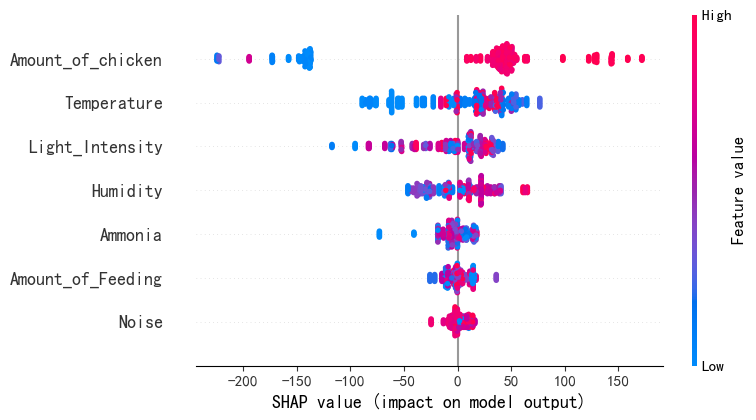

In [60]:
# 可视化所有类别的SHAP 汇总图
shap.summary_plot(shap_values, X_train)

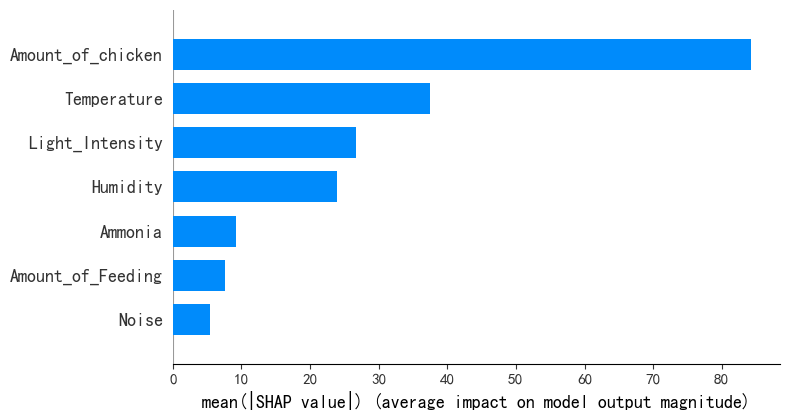

In [61]:
# SHAP 汇总图设置为条形图，可以显示特征重要性
# 这是回归问题 不是每个类别都有这个类别对应的shap值
shap.summary_plot(shap_values, X_train, plot_type="bar")

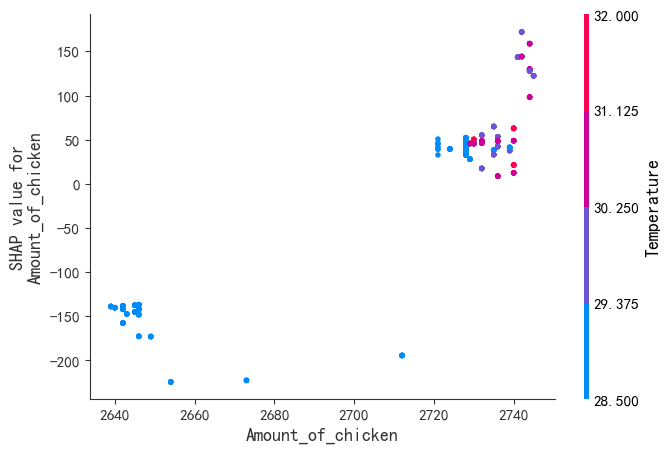

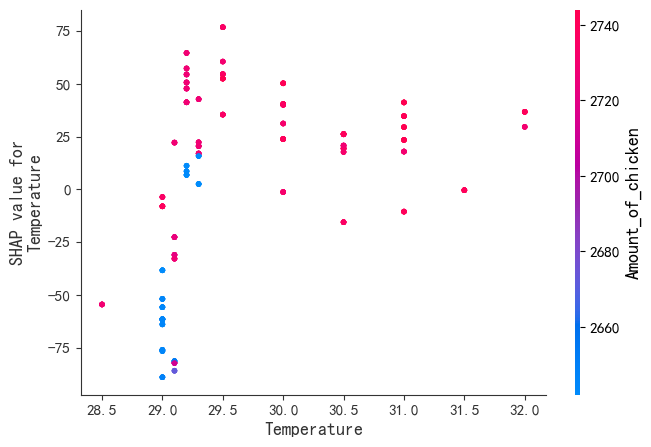

In [65]:
# 同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('Amount_of_chicken', shap_values, X_train, interaction_index="Temperature")
# 同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('Temperature', shap_values, X_train, interaction_index="Amount_of_chicken")

- 第一张图：
左下角区域：有较多蓝色的点，且 SHAP 值为负。这表明在较低温度下，随着鸡量的增加，模型的预测值倾向于降低。
右上方区域：主要是红色和紫色的点，SHAP 值为正。意味着在较高温度下，鸡量的增加会使模型的预测值上升。
中间区域：点的分布较为分散，颜色多样，说明在温度处于中间范围时，鸡量对模型预测值的影响情况较为复杂。
- 第二张图：
左下方区域：主要是蓝色的点，且 SHAP 值为负，说明在鸡量较低的情况下，随着温度的升高，模型的预测值倾向于降低。
上方区域：多为红色的点，SHAP 值大多为正，意味着在鸡量较高时，温度升高会使模型的预测值上升。
中间区域：点的分布较为分散，颜色也较多样，表明当鸡量处于中间范围时，温度对模型预测值的影响情况较为复杂。

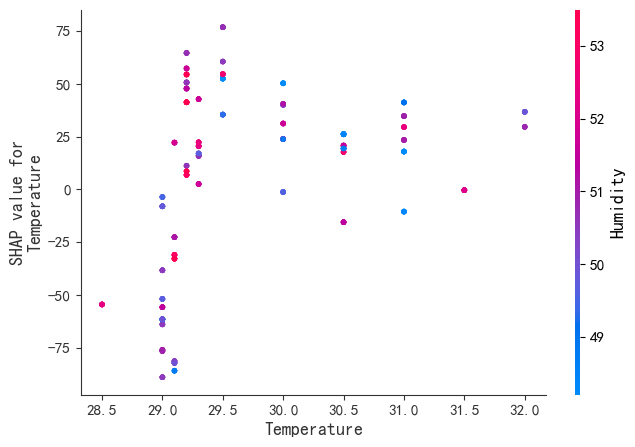

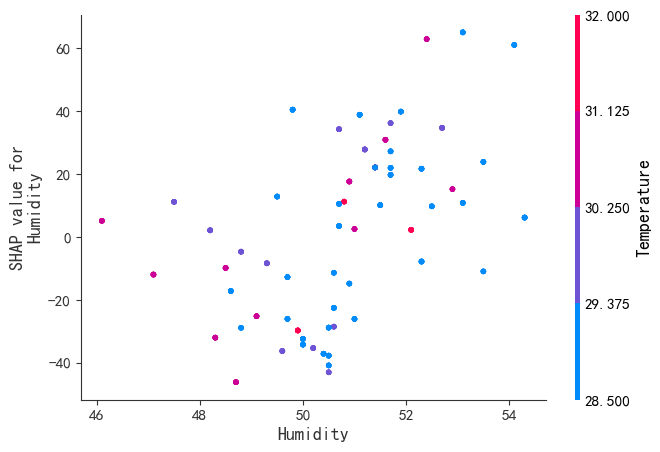

In [66]:
# 同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('Temperature', shap_values, X_train, interaction_index="Humidity")
shap.dependence_plot('Humidity', shap_values, X_train, interaction_index="Temperature")

- 第三张图：
左下方区域：主要是蓝色和紫色的点，且 SHAP 值多为负，意味着在湿度较低的情况下，随着温度升高，模型的预测值倾向于降低。
上方区域：红色和紫色的点较多，SHAP 值多为正，说明在湿度较高时，温度升高会使模型的预测值上升。
中间区域：点分布较分散，颜色多样，表明当湿度处于中间范围时，温度对模型预测值的影响较为复杂。
- 第四张图：
左下方区域：有较多蓝色的点，且 SHAP 值多为负，表明在较低温度下，随着湿度的增加，模型的预测值倾向于降低。
右上方区域：红色和蓝色的点都有分布，SHAP 值多为正，意味着在较高温度时，湿度增加会使模型的预测值上升 。
中间区域：点分布较为分散，颜色多样，说明当温度处于中间范围时，湿度对模型预测值的影响较为复杂。

### 关于单个样本的可解释性分析

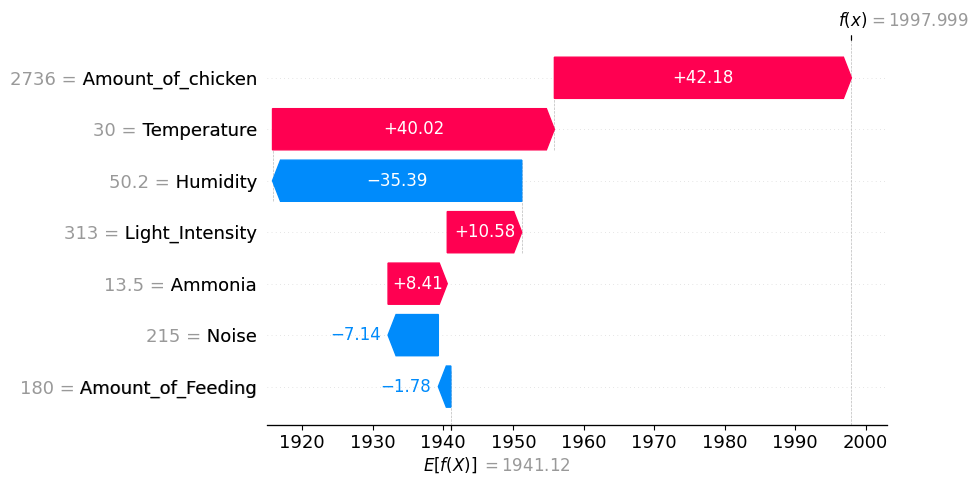

In [ ]:
import shap
import matplotlib.pyplot as plt

# 获取第一个样本的 SHAP 值
single_shap_values = shap_values[0]
# 获取第一个样本的特征值
single_features = X_train.iloc[0] if hasattr(X_train, 'iloc') else X_train[0]
# 创建 Explanation 对象
single_explanation = shap.Explanation(values=single_shap_values, 
                                      base_values=explainer.expected_value, 
                                      data=single_features)

# 可视化第一个样本的 SHAP 值
shap.plots.waterfall(single_explanation)
plt.show()